In [1]:
!pip install jupyterthemes &> /dev/null
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q &> /dev/null
!pip install -q --upgrade keras &> /dev/null

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn,optim
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from statistics import median, mean, quantiles, stdev

In [3]:
import PIL
from PIL import Image, ImageFilter, ImageOps

In [4]:
from jupyterthemes import jtplot
jtplot.style()

In [5]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import ops

In [6]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# GPU

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Dataset and Dataloader

In [8]:
PATH = '/content/gdrive/MyDrive/BreastCancer/'
IMAGES_ROOT_PATH = PATH + 'kerascv/'
MODELS_PATH = PATH + 'segmentation/results/'
SEED = 666
TEST_SIZE = 0.1
VALID_SIZE = 0.1
BATCH_SIZE = 8
YOLO = 'yolo_v8_m_backbone_coco'
RETINA = 'resnet34'
DETECTOR = YOLO
MALIGNANT = 1
BENIGN = 0
NORMAL = 2
CLASS = None
BOUNDING_BOX_FORMAT = 'xyxy'
CLASS_NAMES = ['benign', 'malignant']
class_mapping = dict(zip(range(len(CLASS_NAMES)), CLASS_NAMES))

busi_df = pd.read_csv(PATH + 'mapping_curated_BUSI_unique_bbox.csv')

## Dataset

In [9]:
class BreastCancerDataset(Dataset):
    def __init__(self, data, img_transforms=None, mask_transforms=None, aug_transforms=None):
        self.data = data
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        self.aug_transforms = aug_transforms

    def __len__(self):
        return self.data.shape[0]

    def loadCoords(self, data, idx):
        '''
        left = min(list(map(int, data.iloc[idx].left.split(','))))
        top = min(list(map(int, data.iloc[idx].top.split(','))))
        right = max(list(map(int, data.iloc[idx].right.split(','))))
        bottom = max(list(map(int, data.iloc[idx].bottom.split(','))))
        '''
        left = int(data.iloc[idx].left)
        top = int(data.iloc[idx].top)
        right = int(data.iloc[idx].right)
        bottom = int(data.iloc[idx].bottom)
        return left, top, right, bottom

    def loadImage(self, rel_path, id_class, coords):
        image_name = os.path.join(IMAGES_ROOT_PATH, rel_path)
        img = Image.open(image_name)
        if id_class != 2:
            img_crop = img.crop(coords)
        else:
            img_crop = img

        return img, img_crop

    def __getitem__(self, idx):
        id_class = self.data.iloc[idx]['class']
        img_path =  self.data.iloc[idx].img_path
        if id_class != 2:
            coords = self.loadCoords(self.data, idx)
        else:
            coords = -1, -1, -1, -1 # normal case (not benign or malignant)
        img, img_crop = self.loadImage(img_path, id_class, coords)
        height = img.height
        width = img.width
        img = self.img_transforms(img)
        img_crop = self.img_transforms(img_crop)

        msk_path = self.data.iloc[idx].mask_path
        mask, mask_crop = self.loadImage(msk_path, id_class, coords)
        mask = self.mask_transforms(mask)
        mask_crop = self.mask_transforms(mask_crop)

        if self.aug_transforms is not None:
            state = torch.get_rng_state()
            img_crop = self.aug_transforms(img_crop)
            torch.set_rng_state(state)
            mask_crop = self.aug_transforms(mask_crop)

        ''' Normalizamos la mascara a ceros y unos '''
        mask_max = mask.max().item()
        if (mask_max > 0):
            mask /= mask_max
        mask_crop_max = mask_crop.max().item()
        if (mask_crop_max > 0):
            mask_crop /= mask_crop_max

        return img, mask, img_crop, mask_crop, torch.tensor(coords), id_class, torch.tensor((width, height))




## Transformations

In [10]:
transform_img = T.Compose([
                    T.Resize([224, 224], interpolation=T.InterpolationMode.NEAREST),
                    T.ToTensor()
                ])

transform_mask = T.Compose([
                    T.Resize([224, 224], interpolation=T.InterpolationMode.NEAREST),
                    T.Grayscale(),
                    T.ToTensor()
                ])

transf_aug = T.Compose([
    T.RandomAffine(degrees=0, translate=[0.1, 0.1]),
    T.ColorJitter(saturation=0.5, hue=0.015, brightness=0.25),
    T.RandomApply([T.RandomHorizontalFlip(), T.RandomVerticalFlip()], 0.5),
    T.RandomResizedCrop((224,224),scale=(0.9, 1.1))
    ])

## Model Detector

In [11]:
class BreastCancerDatasetFromDetector(Dataset):
    def __init__(self, data, img_transforms=None, mask_transforms=None, detector=None):
        self.data = data
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        self.detector = detector

    def __len__(self):
        return self.data.shape[0]

    def load_bbox(self, img):
        img_array = np.array(img)
        pred = self.detector.predict(tf.constant([img_array]), verbose=0)
        num_detections = pred['num_detections'][0]
        confidence = pred['confidence']
        boxes = pred['boxes']
        classes = pred['classes']
        if num_detections == 0:
            return pred,(-1, -1, -1, -1)
        else:
            lefts = []
            tops = []
            rights = []
            bottoms = []
            for i in range(num_detections):
                lefts.append(max(math.floor(boxes[0, i, 0]), 0))
                tops.append(max(math.floor(boxes[0, i, 1]), 0))
                rights.append(min(math.ceil(boxes[0, i, 2]), 224))
                bottoms.append(min(math.ceil(boxes[0, i, 3]), 224))
        return pred, (min(lefts), min(tops), max(rights), max(bottoms))

    def load_image(self, rel_path):
        img_path = os.path.join(IMAGES_ROOT_PATH, rel_path)
        img = Image.open(img_path)
        img = img.resize([224, 224], resample=Image.NEAREST)
        return img

    def __getitem__(self, idx):
        id_class = self.data.iloc[idx]['class']

        img = self.load_image(self.data.iloc[idx].img_path)
        mask = self.load_image(self.data.iloc[idx].mask_path)
        pred, bbox = self.load_bbox(img)

        if (bbox[0] == -1):
            img_crop = img
            mask_crop = mask
        else:
            img_crop = img.crop(bbox)
            mask_crop = mask.crop(bbox)

        img = self.img_transforms(img)
        img_crop = self.img_transforms(img_crop)
        mask = self.mask_transforms(mask)
        mask_crop = self.mask_transforms(mask_crop)

        ''' Normalizamos la mascara a ceros y unos '''
        mask_max = mask.max().item()
        if (mask_max > 0):
            mask /= mask_max
        mask_crop_max = mask_crop.max().item()
        if (mask_crop_max > 0):
            mask_crop /= mask_crop_max
        return img, mask, img_crop, mask_crop, pred, torch.tensor(bbox), id_class, torch.tensor((224, 224))

In [12]:
import keras_cv
from keras_cv import bounding_box, visualization

prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format='xyxy',
    from_logits = False,
    iou_threshold=0.25,
    confidence_threshold=0.25,
    max_detections=10
)
if "yolo" in DETECTOR:
    model_detector = keras_cv.models.YOLOV8Detector(
        num_classes=2,
        bounding_box_format='xyxy',
        backbone=keras_cv.models.YOLOV8Backbone.from_preset(DETECTOR)
    )
elif "resnet" in DETECTOR:
    model_detector = keras_cv.models.RetinaNet(
        num_classes=2,
        bounding_box_format='xyxy',
        backbone=(keras_cv.models.ResNet34Backbone(include_rescaling=True, input_shape=(224, 224, 3)).from_preset("resnet34"))
    )
model_detector.prediction_decoder = prediction_decoder
#model_detector.load_weights(f'/content/gdrive/MyDrive/BreastCancer/kerascv/results/best_{DETECTOR}.weights.h5')


100%|██████████| 646/646 [00:00<00:00, 788kB/s]
100%|██████████| 45.6M/45.6M [00:03<00:00, 13.2MB/s]


In [13]:
print(model_detector.summary())

Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, None, None,    │     11,872,464 │ input_layer_1[0][0]    │
│                           │ 192), (None, None,     │                │                        │
│                           │ None, 384), (None,     │                │                        │
│                           │ None, None, 576)]      │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat (Repeat)           │ (None, None, None,     │              0 │ functional[0][2]       │
│                           │ 576)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_1 (Repeat)         │ (None, None, None,     │              0 │ repeat[0][0]           │
│                           │ 576)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ repeat_1[0][0],        │
│ (Concatenate)             │ 960)                   │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │        368,640 │ concatenate_5[0][0]    │
│ (Conv2D)                  │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          1,536 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 192), (None, None,     │                │                        │
│                           │ None, 192)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │        331,776 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │            768 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 25,890,582 (98.76 MB)

 Trainable params: 25,857,462 (98.64 MB)

 Non-trainable params: 33,120 (129.38 KB)

None


## Dataloaders

In [14]:
'''
for i, (x, y) in enumerate(train_loader):
    print(i, x.shape, y.shape)
    if i==9: break
'''
#imgs0, masks0, imgs, masks, coords, dim = next(iter(train_loader))
def plot_mini_batch(imgs=None, masks=None, length=None):
    plt.figure(figsize=(20,20))
    if length is None:
        length = BATCH_SIZE
    for i in range(length):
        plt.subplot(4, length, i+1)
        if imgs is not None:
            img = imgs[i, ...].permute(1,2,0).numpy()
            plt.imshow(img, cmap='Blues')
        if masks is not None:
            mask = masks[i, ...].permute(1,2,0).numpy()
            plt.imshow(mask, cmap='Reds', alpha=0.25)
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

#plot_mini_batch(imgs0, masks0)
#plot_mini_batch(imgs, masks)


In [15]:
#imgs0, masks0, imgs, masks, coords, dim = next(iter(train_loader))
def plot_mini_batch_result(imgs=None, gt_masks=None, pred_masks=None, length=None, boxes_pred=None):
    plt.figure(figsize=(20,20))
    if length is None:
        length = BATCH_SIZE
    boxes_pred['boxes']=tf.reshape(boxes_pred['boxes'], (length, 1, 4))
    boxes_pred['classes']=tf.reshape(boxes_pred['classes'], (length, 1))
    boxes_pred['confidence']=tf.reshape(boxes_pred['confidence'], (length, 1))
    imgs = (255 * imgs).permute(0,2,3,1)
    imgs = draw_bounding_boxes(imgs, boxes_pred, (255, 235, 59), BOUNDING_BOX_FORMAT, line_thickness=2, text_thickness=2, font_scale=0.45, class_mapping=class_mapping)
    #imgs = draw_bounding_boxes(imgs, boxes_pred, (0, 188, 212), BOUNDING_BOX_FORMAT, line_thickness=2, text_thickness=2, font_scale=0.5, class_mapping=class_mapping)

    for i in range(length):
        plt.subplot(4, length, i+1)
        if imgs is not None:
            img = imgs[i, ...]
        if gt_masks is not None:
            gt_mask = gt_masks[i, ...].permute(1,2,0).numpy()
        if pred_masks is not None:
            pred_mask = pred_masks[i, ...].permute(1,2,0).numpy()
        result = image_with_gt_and_pred(img, gt_mask, pred_mask)
        plt.imshow(result)
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

#plot_mini_batch(imgs0, masks0)
#plot_mini_batch(imgs, masks)


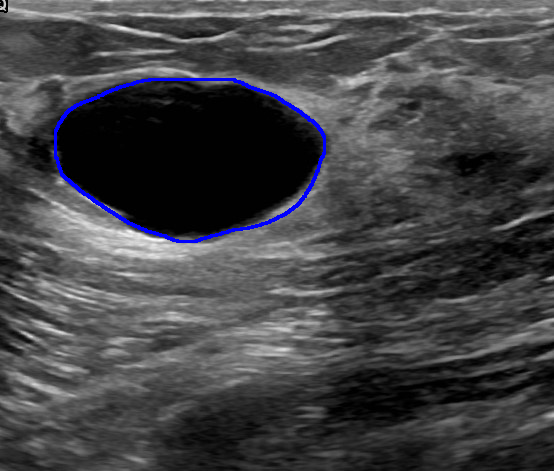

In [16]:
# Load the image
mask_path = f'{PATH}kerascv/masks/benign_id_26_mask.png'
image_path = f'{PATH}kerascv/images/benign_id_26_.png'
mask = Image.open(mask_path)
image = Image.open(image_path).convert("RGBA")

# Apply contour filter
grayscale_image = mask.convert('L')
edges_image = grayscale_image.filter(ImageFilter.FIND_EDGES)
thick_edges_image = edges_image.filter(ImageFilter.MaxFilter(3))
colorized_edges_image = ImageOps.colorize(thick_edges_image, black="black", white="green")

# Convert the thick edges image to RGBA
thick_edges_rgba = thick_edges_image.convert("RGBA")

# Create a new image with the same size and transparent background
transparent_image = Image.new("RGBA", thick_edges_rgba.size, (0, 0, 0, 0))
for y in range(thick_edges_rgba.height):
    for x in range(thick_edges_rgba.width):
        r, g, b, a = thick_edges_rgba.getpixel((x, y))
        if r > 0 or g > 0 or b > 0:  # Detect edges (white parts in the thick edges image)
            transparent_image.putpixel((x, y), (0, 0, 255, 255))  # Set edge color (blue) with full opacity
        else:
            transparent_image.putpixel((x, y), (0, 0, 0, 0))  # Set non-edge parts to transparent

# Merge the transparent edges image onto the background image
image.paste(transparent_image, (0, 0), transparent_image)

# Show the result
image

## Accuracy

In [17]:
def print_stats(stat, elements):
    print(f'{stat} - mean: {mean(elements):.4f}, min: {min(elements):.4f}, percentile-25th: {quantiles(elements)[0]:.4f}, median: {median(elements):.4f}, percentile-75th: {quantiles(elements)[2]:.4f}, max: {max(elements):.4f}, stdev: {stdev(elements):.4f}')


In [18]:
def preds_crops(preds, coords, training=False):
    preds_copy = torch.clone(preds)
    preds_copy = torch.argmax(preds_copy, dim=1)
    for i in range(preds_copy.shape[0]):
        left = coords[i, 0].item()
        if left==-1 and not training: # No detections
            preds_copy[i, ...] = torch.zeros([1, 224, 224])
    return preds_copy

def preds_full_img(preds, coords, dim0, training=False):
    preds_copy = torch.clone(preds)
    for i in range(preds_copy.shape[0]):
        left = coords[i, 0].item()
        top = coords[i, 1].item()
        right = coords[i, 2].item()
        bottom = coords[i, 3].item()
        if not(left==-1 and top==-1 and right==-1 and bottom==-1):
            preds_full_img = T.Resize([(bottom-top), (right-left)], interpolation=T.InterpolationMode.NEAREST)(preds_copy[i, ...])
            result = torch.zeros([1, dim0[i, 1].item(), dim0[i, 0].item()])
            result[0, top:bottom, left:right] = preds_full_img
            preds_copy[i, ...] = T.Resize([224, 224], interpolation=T.InterpolationMode.NEAREST)(result)
        elif not training: # No detections
            preds_copy[i, ...] = torch.zeros([1, 224, 224])
    return preds_copy

def accuracy(model, loader, crop_integration = True, training = False, index = None):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    correct0 = 0
    intersection0 = 0
    denom0 = 0
    union0 = 0
    total0 = 0
    model = model.to(device=device)
    dices = []
    ious = []
    dices0 = []
    ious0 = []
    classes = torch.tensor([], dtype=int, device=device)
    problems = [109, 268, 296]
    with torch.no_grad():
        for x0, y0, x, y, boxes, coords, id_class, dim in loader:
            i = index + len(dices0)
            mb_size = id_class.size(dim=0)
            identity_mb = torch.eye(mb_size)
            identity_mb = identity_mb.to(device=device, dtype=torch.float32)
            x0 = x0.to(device=device, dtype=torch.float32)
            y0 = y0.to(device=device, dtype=torch.long).squeeze(1) #eliminamos la dimension=1 correspondiente a los canales
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1) #eliminamos la dimension=1 correspondiente a los canales
            coords = coords.to(device=device, dtype=torch.int)
            dim = dim.to(device=device, dtype=torch.int)
            id_class = id_class.to(device=device, dtype=torch.int)
            classes = torch.cat((classes, id_class), 0)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            preds = preds_crops(scores, coords, training=training)
            # standard accuracy
            correct += (preds == y).sum()
            total += torch.numel(preds)
            # dice coefficient
            intersection_mb = (preds*y).sum(dim=(1,2))
            denom_mb = (preds + y).sum(dim=(1,2))
            partial_dice = (identity_mb * torch.where(
                        torch.eq(id_class, 2),
                        torch.where((preds).sum(dim=(1,2)) > 0, 0, 1),
                        (2 * intersection_mb) / (denom_mb + 1e-8))
                      ).sum(dim=0).tolist()
            dices += partial_dice

            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2 * intersection / (denom + 1e-8)
            # intersection over union
            union += (preds + y - preds*y).sum()
            union_mb = (preds + y - preds*y).sum(dim=(1,2))
            iou = intersection / (union + 1e-8)
            ious += (identity_mb * torch.where(
                        torch.eq(id_class, 2),
                        torch.where((preds).sum(dim=(1,2)) > 0, 0, 1),
                        intersection_mb / (union_mb + 1e-8))
                      ).sum(dim=0).tolist()

            if crop_integration:
                preds0 = preds_full_img(preds.unsqueeze(1), coords, dim, training=training).squeeze(1)
                # standard accuracy
                correct0 += (preds0 == y0).sum()
                total0 += torch.numel(preds0)
                # dice coefficient
                intersection_mb0 = (preds0 * y0).sum(dim=(1,2))
                denom_mb0 = (preds0 + y0).sum(dim=(1,2))
                partial_dice0 = (identity_mb * torch.where(
                            torch.eq(id_class, 2),
                            torch.where((preds0).sum(dim=(1,2)) > 0, 0, 1),
                            (2 * intersection_mb0) / (denom_mb0 + 1e-8))
                        ).sum(dim=0).tolist()
                dices0 += partial_dice0
                intersection0 += (preds0 * y0).sum()
                denom0 += (preds0 + y0).sum()
                dice0 = 2 * intersection0 / (denom0 + 1e-8)
                # intersection over union
                union_mb0 = (preds0 + y0 - preds0 * y0).sum(dim=(1,2))
                union0 += (preds0 + y0 - preds0 * y0).sum()
                iou0 = intersection0 / (union0 + 1e-8)
                ious0 += (identity_mb * torch.where(
                        torch.eq(id_class, 2),
                        torch.where((preds0).sum(dim=(1,2)) > 0, 0, 1),
                        intersection_mb0 / (union_mb0 + 1e-8))
                      ).sum(dim=0).tolist()
                for j in range(0, mb_size):
                    if i+j+1 in problems:
                        print(j+1)
                        print(id_class)
                        print(partial_dice0)
                        print(preds0.sum(dim=(1,2)))
                        print(coords)

    if not crop_integration:
        return cost/len(loader), (correct)/total, dice, iou, dices, ious

    return cost/len(loader), (correct)/total, dice, iou, dices, ious, (correct0)/total0, dice0, iou0, dices0, ious0, classes


### Search for learning rate

In [19]:
def find_lr(model, optimiser, start_val = 1e-6, end_val = 1, beta = 0.99, loader = None):
    n = len(loader) - 1
    factor = (end_val / start_val)**(1/n)
    lr = start_val
    optimiser.param_groups[0]['lr'] = lr #this allows you to update the learning rate
    avg_loss, loss, acc = 0., 0., 0.
    lowest_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    accuracies = []
    model = model.to(device=device)
    loss_fn = DiceBCELoss().to(device=device)
    for i, (x0, y0, x, y, coords, id_class, dim) in enumerate(loader, start=1):
        x = x.to(device = device, dtype = torch.float32)
        y = y.to(device = device, dtype = torch.long).squeeze(1)
        print(id_class)
        id_class = id_class.to(device = device, dtype = torch.int)
        optimiser.zero_grad()
        scores = model(x)
        #cost = F.cross_entropy(input=scores, target=y)
        cost = loss_fn(scores, y, id_class)
        loss = beta*loss + (1-beta)*cost.item()
        #bias correction
        avg_loss = loss/(1 - beta**i)

        preds = torch.argmax(scores, dim=1)
        acc_ = (preds == y).sum()/torch.numel(scores)
#         acc = beta*acc + (1-beta)*acc_.item()
#         avg_acc = acc/(1 - beta**i)
        #if loss is massive stop
        if i > 1 and avg_loss > 4 * lowest_loss:
            print(f'from here{i, cost.item()}')
            return log_lrs, losses, accuracies
        if avg_loss < lowest_loss or i == 1:
            lowest_loss = avg_loss

        accuracies.append(acc_.item())
#         accuracies.append(avg_acc)
        losses.append(avg_loss)
        log_lrs.append(lr)
        #step
        cost.backward()
        optimiser.step()
        #update lr
        print(f'cost:{cost.item():.4f}, lr: {lr:.4f}, acc: {acc_.item():.4f}')
        lr *= factor
        optimiser.param_groups[0]['lr'] = lr

    return log_lrs, losses, accuracies

## Train loop

In [20]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, classes, smooth=1):
        mb_size = classes.size(dim=0)
        identity_mb = torch.eye(mb_size)
        identity_mb = identity_mb.to(device=device, dtype=torch.float32)
        BCE = F.cross_entropy(inputs, targets)
        inputs =  torch.argmax(inputs, dim=1)

        intersection = (inputs * targets).sum(dim=(1,2))

        dice_loss = (identity_mb * torch.where(
                        torch.eq(classes, 2),
                        torch.where((inputs).sum(dim=(1,2)) > 0, 0, 1),
                        1 - ((2.*intersection + smooth)/(inputs.sum(dim=(1,2)) + targets.sum(dim=(1,2)) + smooth)))
                    ).sum(dim=0)
        #print(f'BCE: {BCE} - dice_loss: {dice_loss.mean().item()}')
        Dice_BCE = BCE + dice_loss.mean()

        return Dice_BCE

In [21]:
def train(model, loader = None, val_loader = None, optimiser = None, scheduler = None, epochs = 100, store_limit = 0.70, train_crops = True):
    model = model.to(device=device)
    loss_fn = DiceBCELoss().to(device=device)
    for epoch in range(epochs):
        train_correct_num = 0
        train_total = 0
        train_cost_acum = 0
        for mb, (x0, y0, x, y, coords, id_class, dim) in enumerate(train_loader, start=1):
            model.train()
            if train_crops:
                x = x.to(device=device, dtype=torch.float32)
                y = y.to(device=device, dtype=torch.long).squeeze(1) #eliminamos la dimension=1 correspondiente a los canales
            else:
                x = x0.to(device=device, dtype=torch.float32)
                y = y0.to(device=device, dtype=torch.long).squeeze(1) #eliminamos la dimension=1 correspondiente a los canales
            id_class = id_class.to(device=device, dtype=torch.int)
            print(id_class)
            scores = model(x)
            #cost = F.cross_entropy(input=scores, target=y)
            cost = loss_fn(scores, y, id_class)
            optimiser.zero_grad() # reseteamos los gradientes acumulados
            cost.backward() # calculamos los gradientes
            optimiser.step() # actualizamos los parametros de la red neuronal
            if scheduler: scheduler.step() # actualizamos el learning rate
            train_predictions = torch.argmax(scores, dim=1) # nos quedamos con la clase de probabilidad maxima en los scores a traves de los canales (dim=1)
            train_correct_num += (train_predictions == y).sum() # sumatorio de pixeles en los cuales coinciden las predicciones y la mascara real
            train_total += torch.numel(train_predictions) # 'numel' nos da el numero de elementos
            train_cost_acum += cost.item()

        val_cost, val_acc, dice, iou, dices, ious = accuracy(model, val_loader, crop_integration=False, training=True)
        train_acc = float(train_correct_num) / train_total
        train_cost_every = float(train_cost_acum) / mb
        print(f'epoch: {epoch}, mb: {mb}, train_cost: {train_cost_every:.4f}, val cost: {val_cost:.4f}, ',
                      f'train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, dice: {dice}, iou = {iou}')
        print(f'dice - mean: {mean(dices):.4f}, min: {min(dices):.4f}, percentile-25th: {quantiles(dices)[0]:.4f}, median: {median(dices):.4f}, percentile-75th: {quantiles(dices)[2]:.4f}, max: {max(dices):.4f}, stdev: {stdev(dices):.4f}')
        print(f'iou - mean: {mean(ious):.4f}, min: {min(ious):.4f}, percentile-25th: {quantiles(ious)[0]:.4f}, median: {median(ious):.4f}, percentile-75th: {quantiles(ious)[2]:.4f}, max: {max(ious):.4f}, stdev: {stdev(ious):.4f}')
        mean_dice = mean(dices)
        if mean_dice > store_limit:
            store_limit = mean_dice
            file_name = f'best_{epoch}epochs_{mean_dice:.4f}.pt'
            torch.save(model, MODELS_PATH + file_name)
            print(f'Saving file: {file_name}')
        print('**********************************')


## U-Net model

In [22]:
class Conv_3_k(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv(x)

In [23]:
class Double_Conv(nn.Module):
    '''
    Double convolution block for U-Net
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.double_conv = nn.Sequential(
                                Conv_3_k(channels_in, channels_out),
                                nn.BatchNorm2d(channels_out),
                                nn.ReLU(),
                                Conv_3_k(channels_out, channels_out),
                                nn.BatchNorm2d(channels_out),
                                nn.ReLU()
                            )

    def forward(self, x):
        return self.double_conv(x)

In [24]:
class Down_Conv(nn.Module):
    '''
    Down convolution flow: Double convolution + MaxPool
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.encoder = nn.Sequential(
                            nn.MaxPool2d(2,2),
                            Double_Conv(channels_in, channels_out)
                        )

    def forward(self, x):
        return self.encoder(x)

In [25]:
class Up_Conv(nn.Module):
    '''
    Up convolution flow
    '''
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.upsample_layer = nn.Sequential(
                            nn.Upsample(scale_factor=2, mode='bicubic'),
                            nn.Conv2d(channels_in, channels_in//2, kernel_size=1, stride=1) #Conv 1x1
                        )
        self.decoder = Double_Conv(channels_in, channels_out)

    def forward(self, x1, x2):
        '''
        x1 = Upsampled volume
        x1 = Downsampled volume to concatenate
        '''
        x1 = self.upsample_layer(x1)
        x = torch.cat([x2, x1], dim=1) #dim=1 -> channels dimension

        return self.decoder(x)

In [26]:
class UNET(nn.Module):
    '''
    UNET model
    '''
    def __init__(self, channels_in, channels, num_classes):
        super().__init__()
        self.first_conv = Double_Conv(channels_in, channels) #64, 224, 224
        self.down_conv1 = Down_Conv(channels, 2*channels) #128, 112, 112
        self.down_conv2 = Down_Conv(2*channels, 4*channels) #256, 56, 56
        self.down_conv3 = Down_Conv(4*channels, 8*channels) #512, 28, 28

        self.middle_conv = Down_Conv(8*channels, 16*channels) #1024, 14, 14

        self.up_conv1 = Up_Conv(16*channels, 8*channels)
        self.up_conv2 = Up_Conv(8*channels, 4*channels)
        self.up_conv3 = Up_Conv(4*channels, 2*channels)
        self.up_conv4 = Up_Conv(2*channels, channels)

        self.last_conv = nn.Conv2d(channels, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        x1 = self.first_conv(x)
        x2 = self.down_conv1(x1)
        x3 = self.down_conv2(x2)
        x4 = self.down_conv3(x3)

        x5 = self.middle_conv(x4)

        u1 = self.up_conv1(x5, x4)
        u2 = self.up_conv2(u1, x3)
        u3 = self.up_conv3(u2, x2)
        u4 = self.up_conv4(u3, x1)

        return self.last_conv(u4)

def test():
    x = torch.randn((32, 3, 224, 224))
    model = UNET(3, 64, 2)
    return model(x)

#preds = test()
#print(preds.shape)

## Train model

fold: 0
  Train: [166, 123, 48]
cost:1.2814, lr: 0.0000, acc: 0.2679
cost:1.2890, lr: 0.0000, acc: 0.2486
cost:1.3158, lr: 0.0000, acc: 0.2751
cost:1.3062, lr: 0.0000, acc: 0.2494
cost:1.1916, lr: 0.0000, acc: 0.2637
cost:1.3972, lr: 0.0000, acc: 0.2693
cost:1.3185, lr: 0.0000, acc: 0.2538
cost:1.2508, lr: 0.0000, acc: 0.2405
cost:1.1236, lr: 0.0000, acc: 0.2547
cost:1.1651, lr: 0.0000, acc: 0.2724
cost:1.3206, lr: 0.0000, acc: 0.2633
cost:1.2297, lr: 0.0001, acc: 0.2478
cost:1.2724, lr: 0.0001, acc: 0.2674
cost:1.1528, lr: 0.0001, acc: 0.2556
cost:1.1429, lr: 0.0002, acc: 0.2559
cost:1.2699, lr: 0.0003, acc: 0.2916
cost:1.1338, lr: 0.0005, acc: 0.2871
cost:1.2299, lr: 0.0007, acc: 0.2899
cost:1.0410, lr: 0.0010, acc: 0.3370
cost:1.0433, lr: 0.0015, acc: 0.3117
cost:0.8853, lr: 0.0022, acc: 0.3756
cost:0.9843, lr: 0.0032, acc: 0.3648
cost:0.8103, lr: 0.0046, acc: 0.3703
cost:0.9701, lr: 0.0068, acc: 0.3712
cost:1.2597, lr: 0.0100, acc: 0.3764
cost:1.2190, lr: 0.0147, acc: 0.3921
cost:1

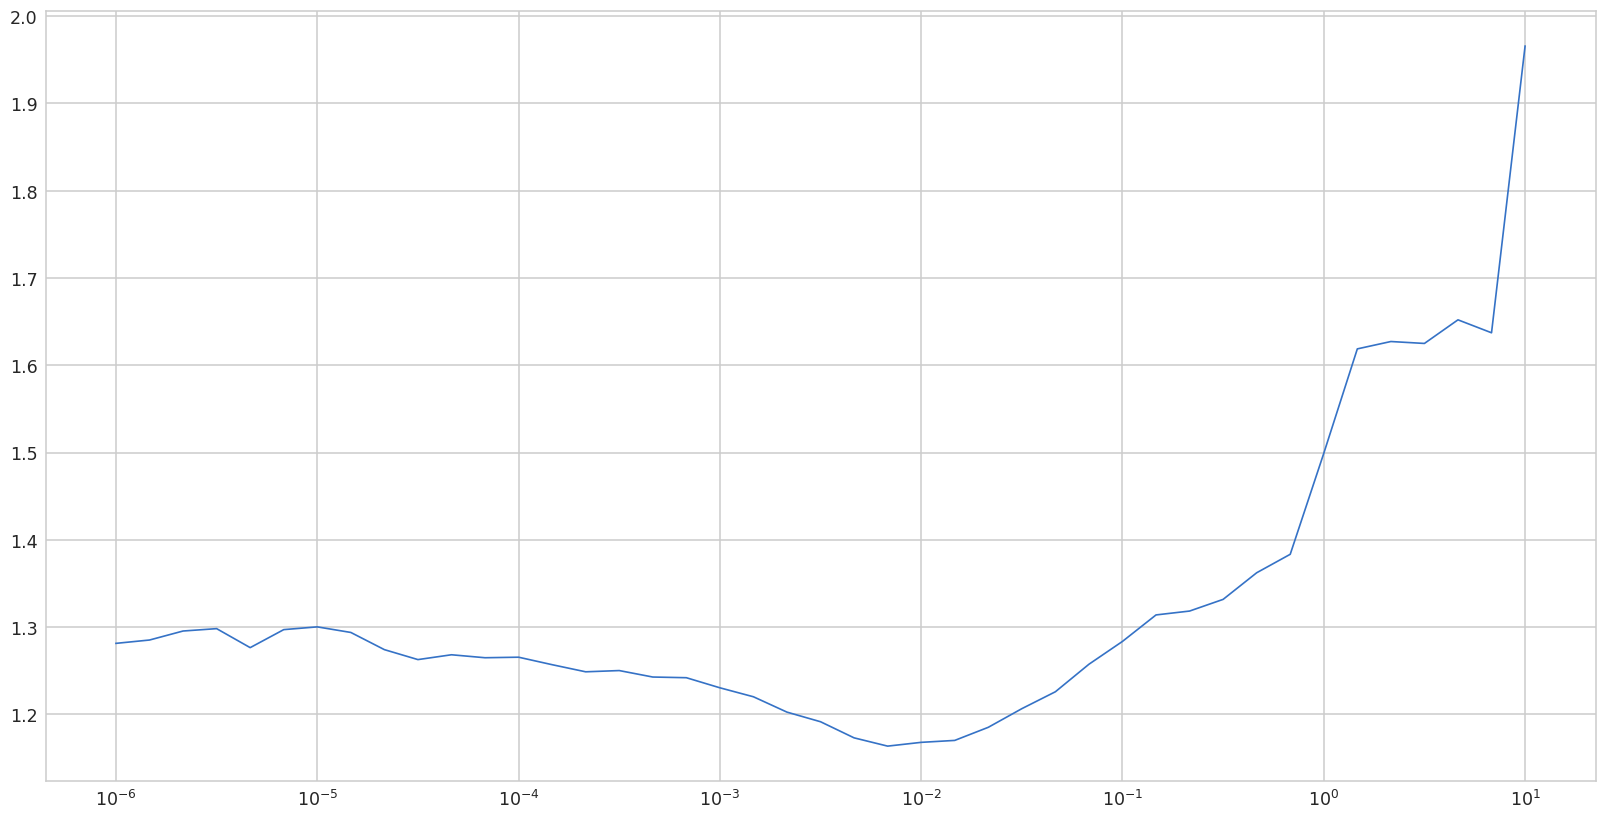

fold: 1
  Train: [166, 123, 48]
cost:1.2956, lr: 0.0000, acc: 0.2646
cost:1.2674, lr: 0.0000, acc: 0.2452
cost:1.4258, lr: 0.0000, acc: 0.2737
cost:1.2950, lr: 0.0000, acc: 0.2516
cost:1.1584, lr: 0.0000, acc: 0.2555
cost:1.3830, lr: 0.0000, acc: 0.2651
cost:1.3347, lr: 0.0000, acc: 0.2545
cost:1.2379, lr: 0.0000, acc: 0.2398
cost:1.1185, lr: 0.0000, acc: 0.2565
cost:1.2077, lr: 0.0000, acc: 0.2548
cost:1.3456, lr: 0.0000, acc: 0.2552
cost:1.2670, lr: 0.0001, acc: 0.2428
cost:1.2897, lr: 0.0001, acc: 0.2633
cost:1.1454, lr: 0.0001, acc: 0.2504
cost:1.1873, lr: 0.0002, acc: 0.2550
cost:1.2718, lr: 0.0003, acc: 0.2934
cost:1.1393, lr: 0.0005, acc: 0.2848
cost:1.1544, lr: 0.0007, acc: 0.3037
cost:0.9907, lr: 0.0010, acc: 0.3505
cost:1.0023, lr: 0.0015, acc: 0.3168
cost:0.9899, lr: 0.0022, acc: 0.3563
cost:0.9463, lr: 0.0032, acc: 0.3568
cost:0.9028, lr: 0.0046, acc: 0.3542
cost:1.1186, lr: 0.0068, acc: 0.3465
cost:1.4210, lr: 0.0100, acc: 0.3818
cost:1.4742, lr: 0.0147, acc: 0.3948
cost:1

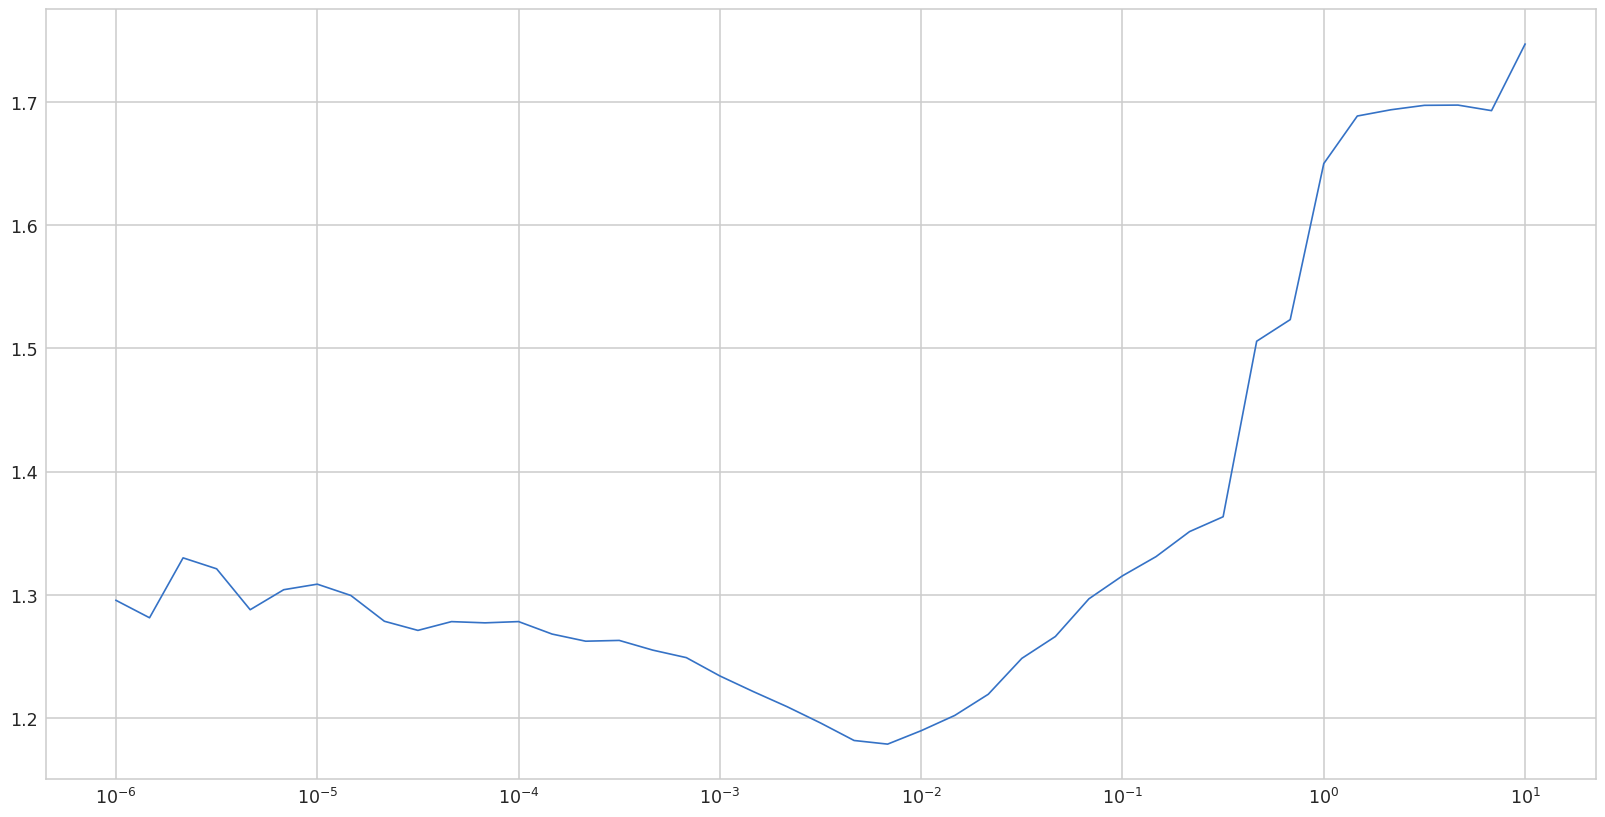

fold: 2
  Train: [167, 123, 48]
cost:1.3737, lr: 0.0000, acc: 0.2648
cost:1.3096, lr: 0.0000, acc: 0.2735
cost:1.0790, lr: 0.0000, acc: 0.2639
cost:1.2489, lr: 0.0000, acc: 0.2598
cost:1.2838, lr: 0.0000, acc: 0.2344
cost:1.2722, lr: 0.0000, acc: 0.2524
cost:1.3544, lr: 0.0000, acc: 0.2588
cost:1.2512, lr: 0.0000, acc: 0.2741
cost:1.2897, lr: 0.0000, acc: 0.2786
cost:1.3837, lr: 0.0000, acc: 0.2714
cost:1.2330, lr: 0.0000, acc: 0.2462
cost:1.2145, lr: 0.0001, acc: 0.2496
cost:1.1986, lr: 0.0001, acc: 0.2510
cost:1.3404, lr: 0.0001, acc: 0.2820
cost:1.0546, lr: 0.0002, acc: 0.2555
cost:1.1833, lr: 0.0003, acc: 0.2958
cost:1.2440, lr: 0.0005, acc: 0.2842
cost:1.1727, lr: 0.0007, acc: 0.3119
cost:1.1520, lr: 0.0010, acc: 0.2647
cost:1.2582, lr: 0.0015, acc: 0.3185
cost:0.9584, lr: 0.0022, acc: 0.3534
cost:0.8861, lr: 0.0032, acc: 0.3630
cost:0.9797, lr: 0.0046, acc: 0.3764
cost:1.0109, lr: 0.0068, acc: 0.3632
cost:1.1858, lr: 0.0100, acc: 0.3855
cost:1.3958, lr: 0.0147, acc: 0.4117
cost:1

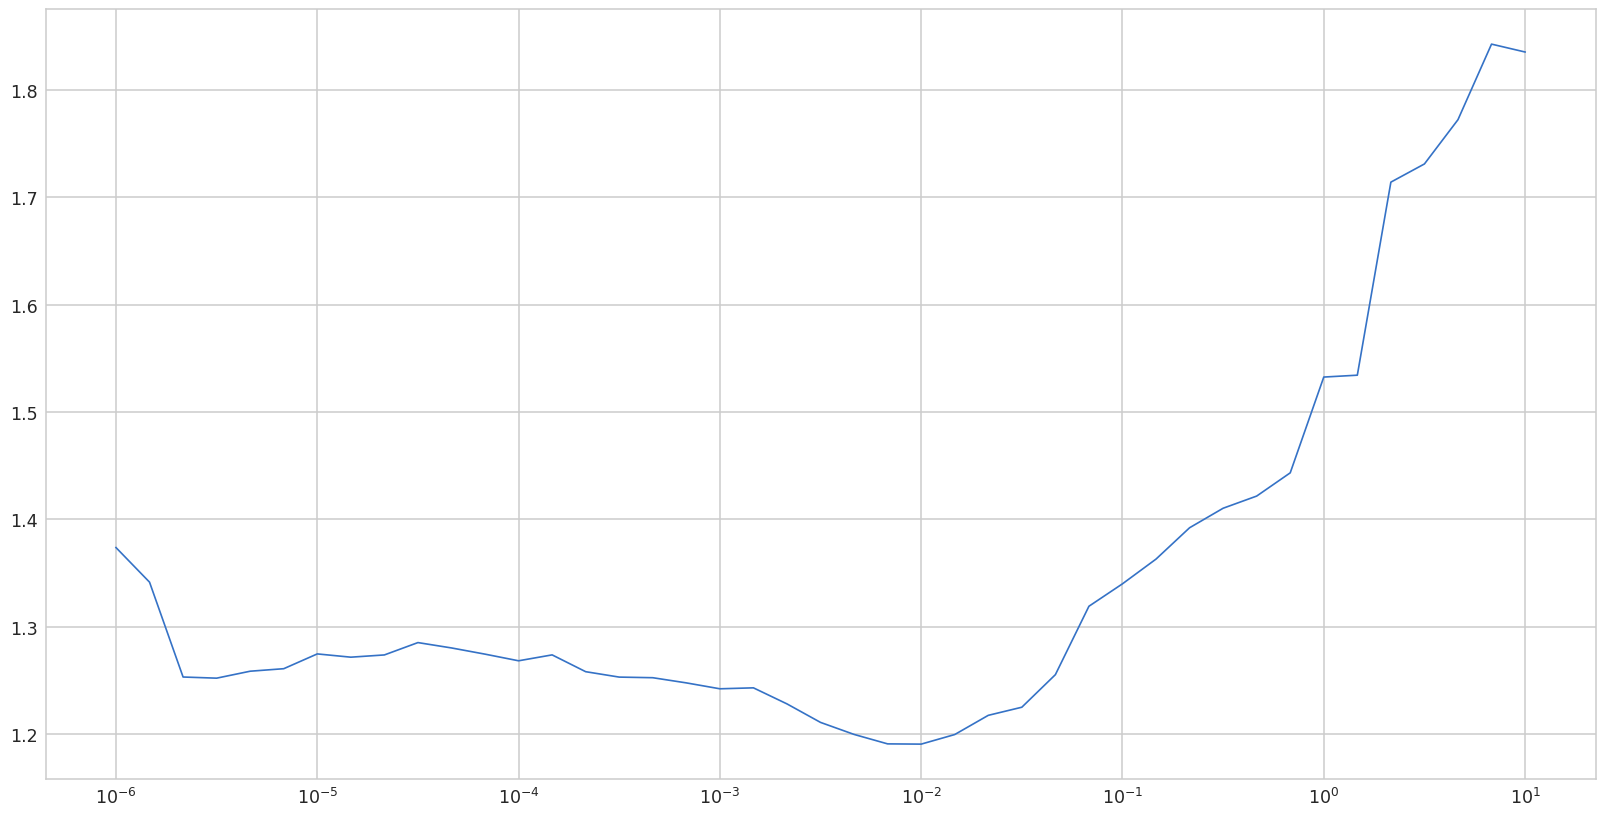

fold: 3
  Train: [167, 123, 48]
cost:1.4001, lr: 0.0000, acc: 0.2760
cost:1.2997, lr: 0.0000, acc: 0.2751
cost:1.1103, lr: 0.0000, acc: 0.2601
cost:1.2991, lr: 0.0000, acc: 0.2671
cost:1.2101, lr: 0.0000, acc: 0.2730
cost:1.3250, lr: 0.0000, acc: 0.2457
cost:1.3551, lr: 0.0000, acc: 0.2561
cost:1.2338, lr: 0.0000, acc: 0.2770
cost:1.3158, lr: 0.0000, acc: 0.2806
cost:1.4073, lr: 0.0000, acc: 0.2647
cost:1.2690, lr: 0.0000, acc: 0.2463
cost:1.2344, lr: 0.0001, acc: 0.2353
cost:1.1911, lr: 0.0001, acc: 0.2615
cost:1.3780, lr: 0.0001, acc: 0.2843
cost:1.0098, lr: 0.0002, acc: 0.2705
cost:1.2147, lr: 0.0003, acc: 0.2836
cost:1.2305, lr: 0.0005, acc: 0.2895
cost:1.1801, lr: 0.0007, acc: 0.3058
cost:1.0616, lr: 0.0010, acc: 0.2944
cost:1.2895, lr: 0.0015, acc: 0.3105
cost:0.9255, lr: 0.0022, acc: 0.3664
cost:0.9517, lr: 0.0032, acc: 0.3484
cost:1.1069, lr: 0.0046, acc: 0.3590
cost:1.0196, lr: 0.0068, acc: 0.3626
cost:1.2079, lr: 0.0100, acc: 0.3859
cost:1.4355, lr: 0.0147, acc: 0.4017
cost:1

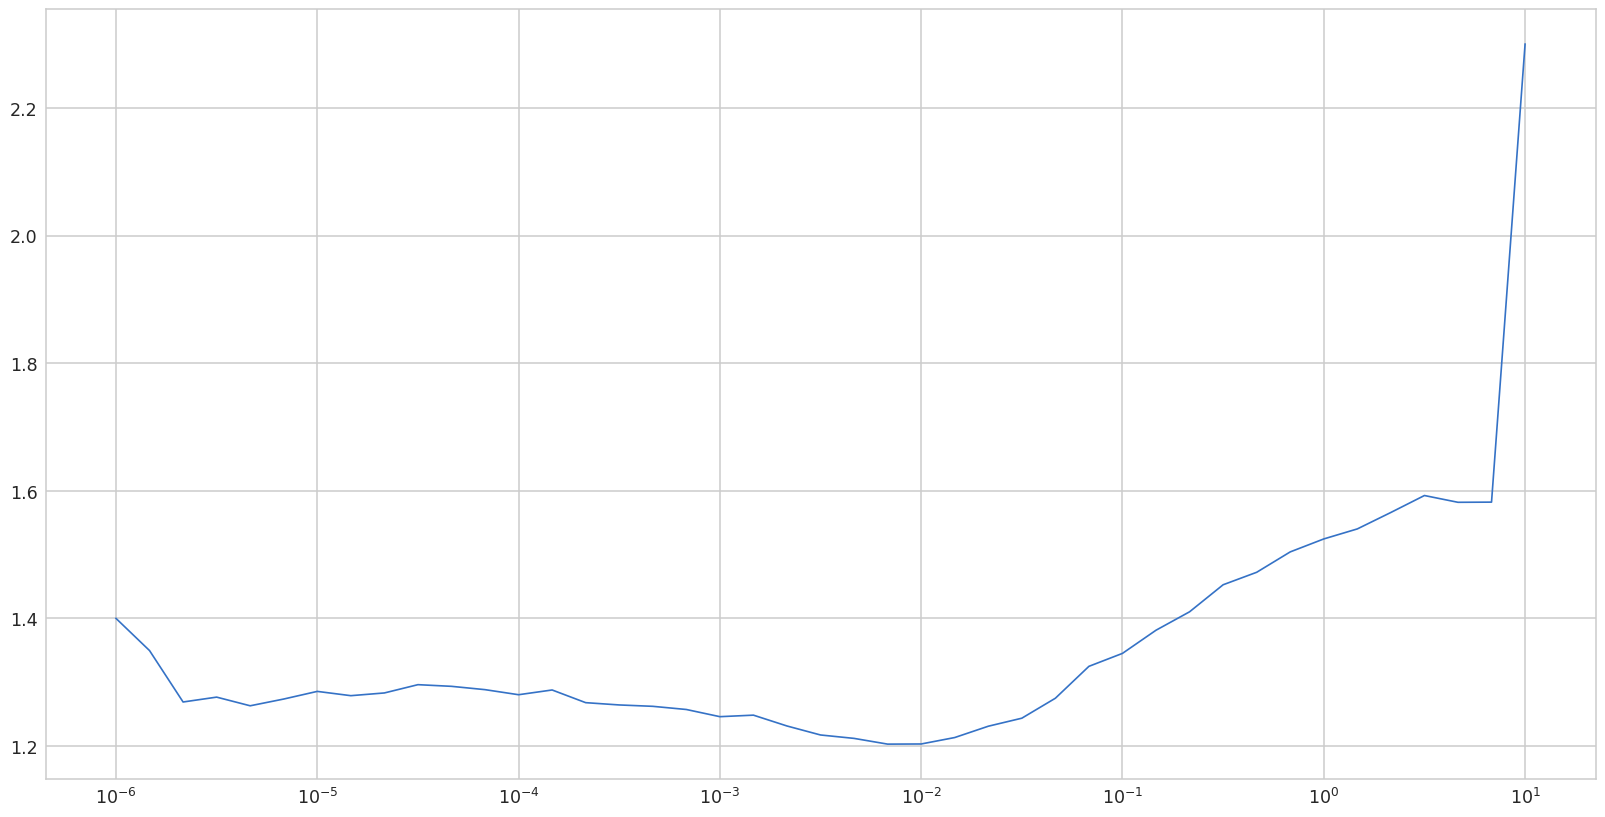

In [ ]:
for fold in range(0,4):
    print(f'fold: {fold}')
    X_train = busi_df[busi_df.test_fold != fold]
    print(f"  Train: {X_train.groupby(['class'])['class'].count().tolist()}")
    train_dataset = BreastCancerDataset(X_train, transform_img, transform_mask, transf_aug)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    torch.manual_seed(SEED)
    model = UNET(3, 64, 2)
    optimiser_unet = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.95, weight_decay=1e-4)

    lg_lr, losses, accuracies = find_lr(model, optimiser_unet, start_val = 1e-6, end_val=10, loader=train_loader)

    f1, ax1 = plt.subplots(figsize=(20, 10))
    ax1.plot(lg_lr, losses)
    ax1.set_xscale('log')
    plt.show()


In [ ]:
models = [f'{PATH}segmentation/results/best_69epochs_fold0_0.8544.pt',
          f'{PATH}segmentation/results/best_66epochs_fold1_0.8447.pt',
          f'{PATH}segmentation/results/best_76epochs_fold2_0.8377.pt',
          f'{PATH}segmentation/results/best_94epochs_fold3_0.8347.pt']

for fold in range(2,3):
    print(f'fold: {fold}')
    # define the model and train with scheduler
    torch.manual_seed(SEED)
    #model = UNET(3, 64, 2)
    model = torch.load(models[fold])
    epochs =50

    X_train = busi_df[busi_df.test_fold != fold]
    X_valid = busi_df[busi_df.test_fold == fold]

    print(f"  Train: {X_train.groupby(['class'])['class'].count().tolist()}")
    print(f"  Valid: {X_valid.groupby(['class'])['class'].count().tolist()}")

    train_dataset = BreastCancerDataset(X_train, transform_img, transform_mask, transf_aug)
    val_dataset = BreastCancerDataset(X_valid, transform_img, transform_mask)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

    optimiser_unet = torch.optim.SGD(model.parameters(),
                                    lr=0.008, momentum=0.95,
                                    weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet,
                                                    max_lr = 1e-1,
                                                    steps_per_epoch=len(train_loader),
                                                    epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                    three_phase=True)

    train(model, train_loader, val_loader, optimiser_unet, scheduler, epochs, train_crops=True)

fold: 2
  Train: [167, 123, 48]
  Valid: [55, 41, 16]


KeyboardInterrupt: 

## Plot some images

In [ ]:
model = torch.load(MODELS_PATH + 'best_81epochs_0.8961.pt')

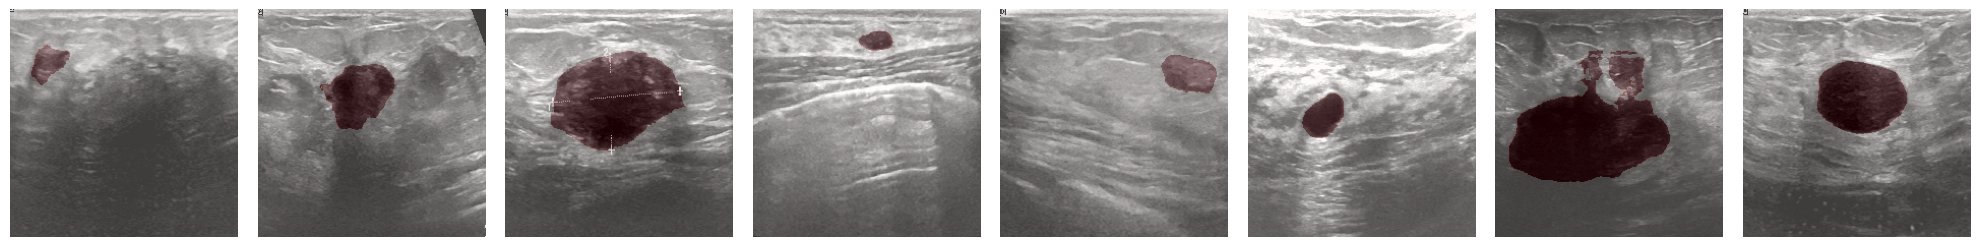

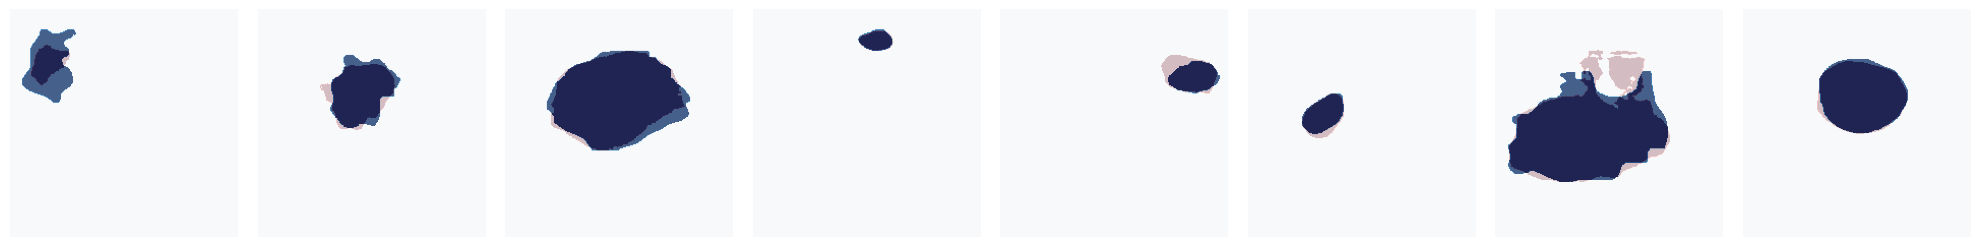

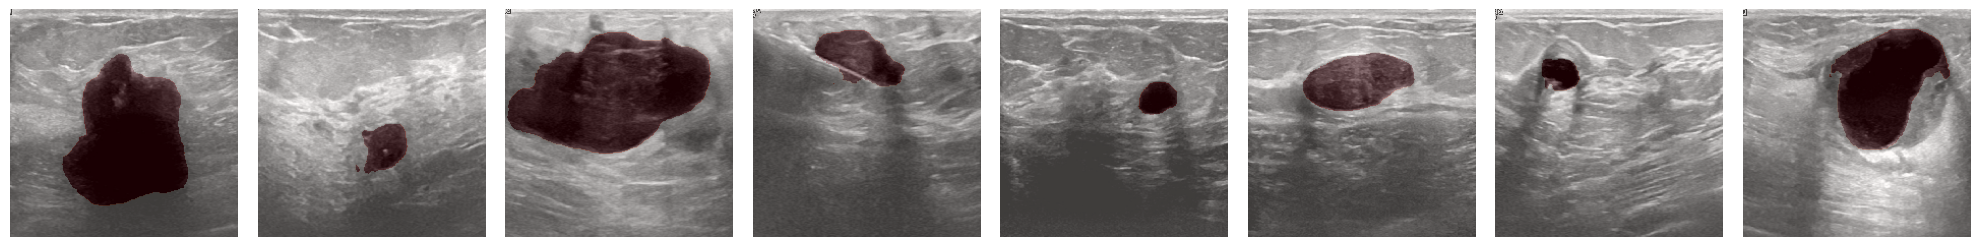

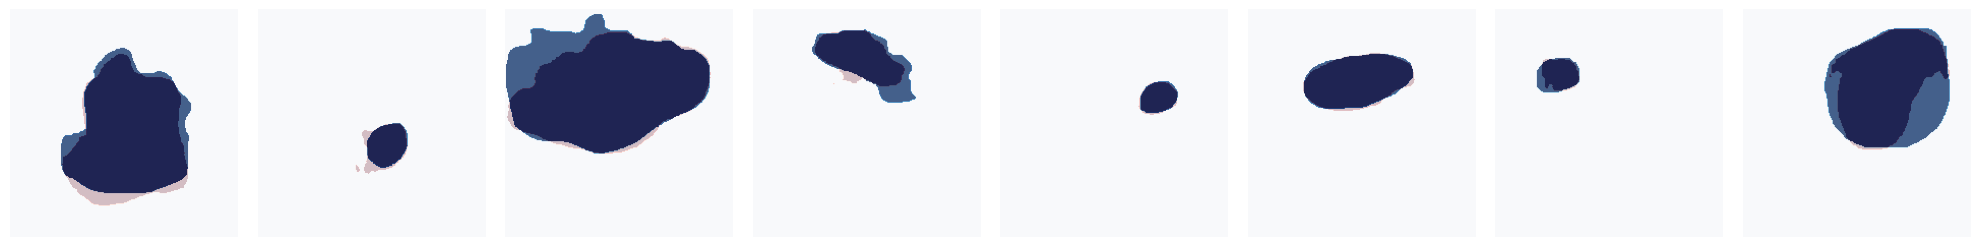

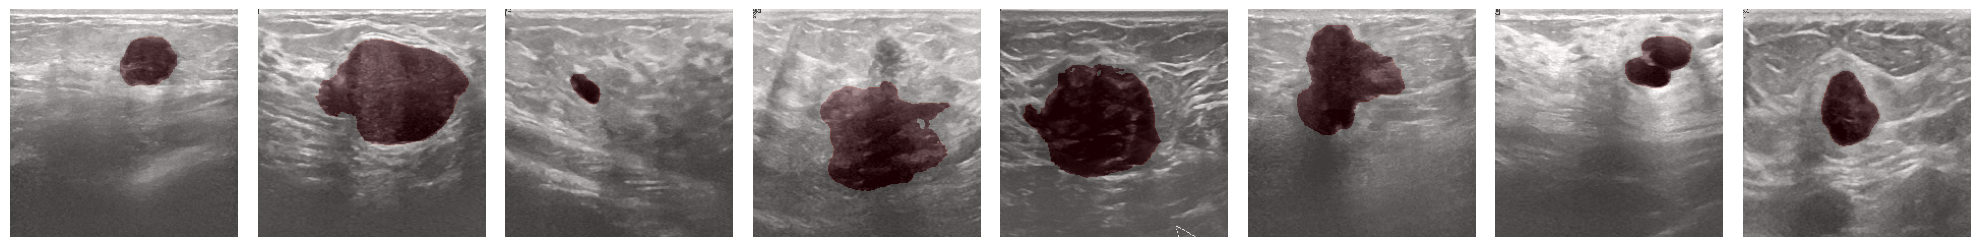

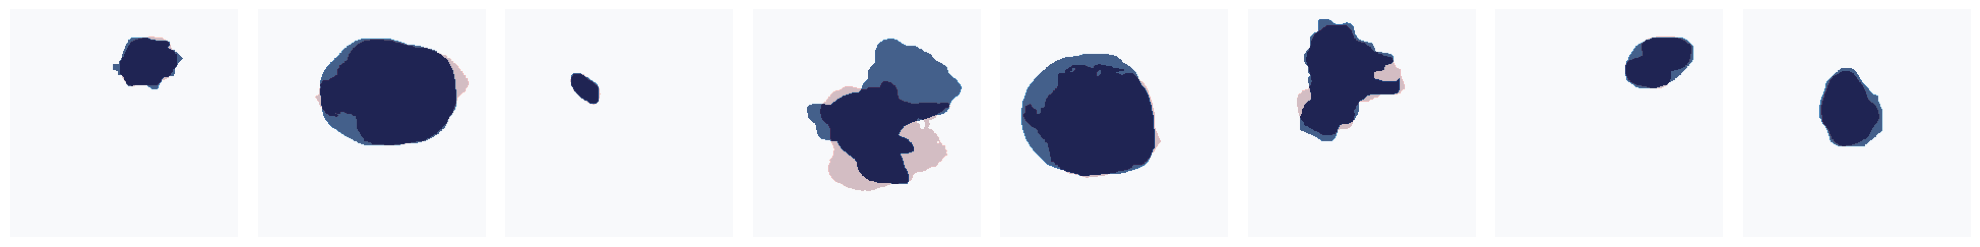

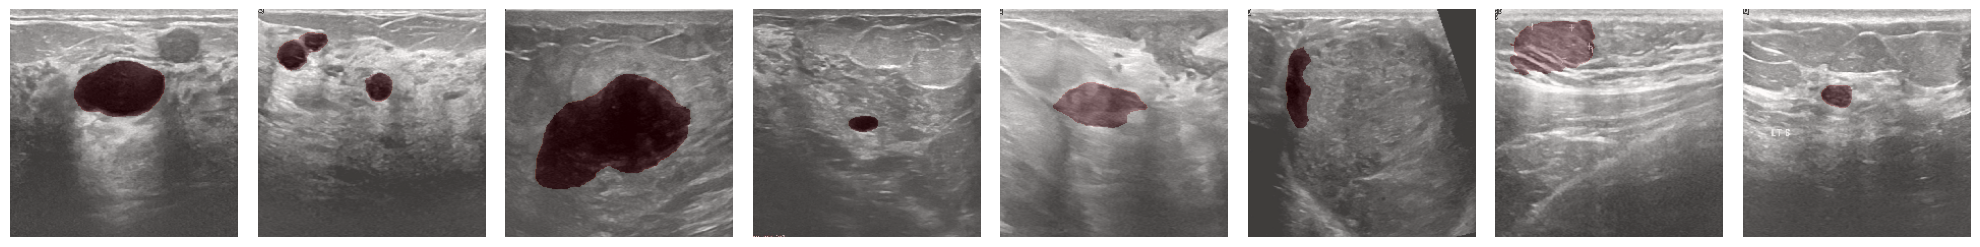

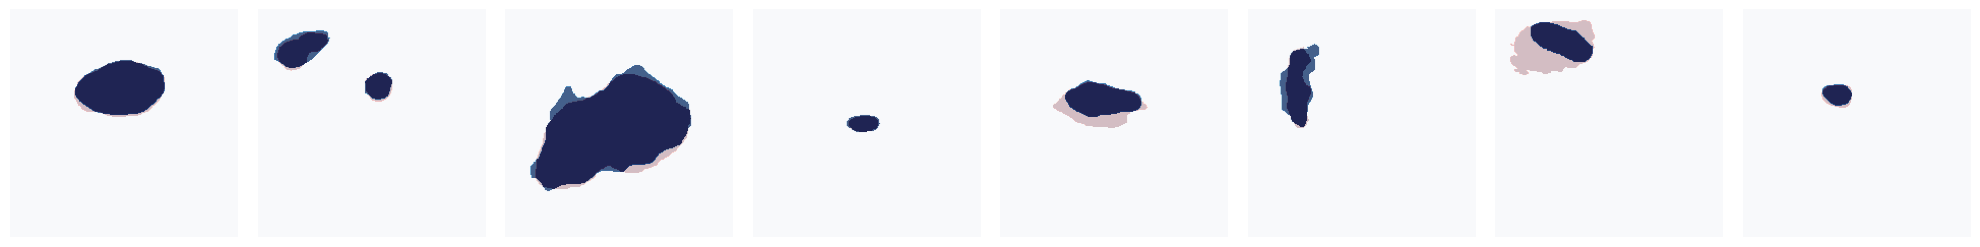

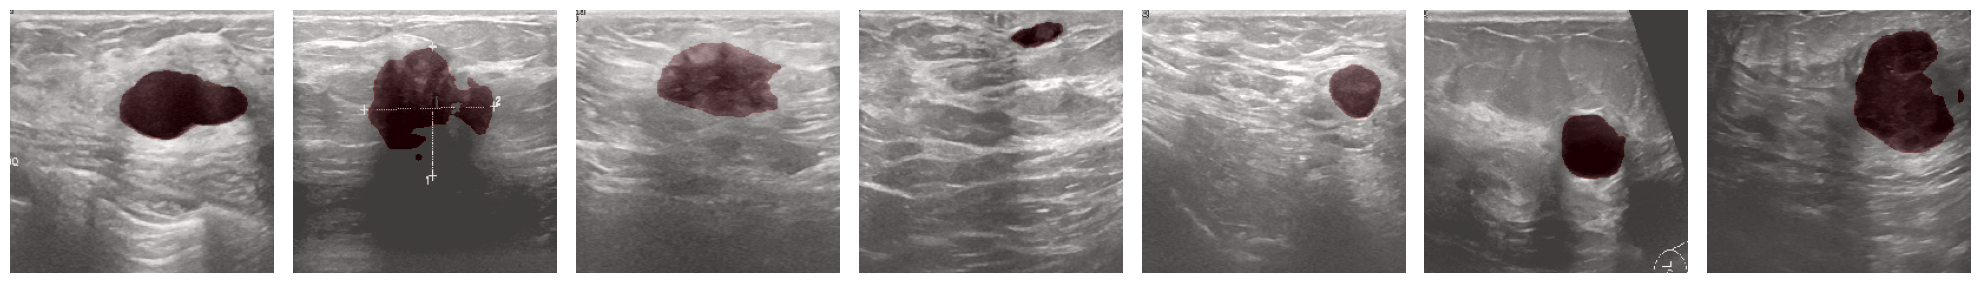

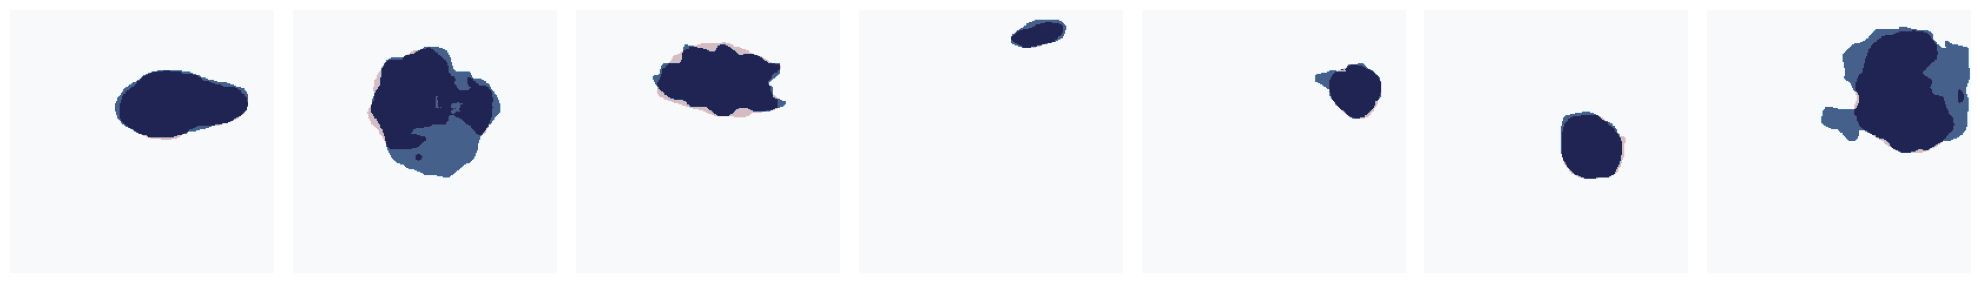

In [ ]:
for step, (imgs0, masks0, imgs, masks, coords, dim) in enumerate(test_loader_optimo):
    imgs = imgs.to(device, dtype=torch.float32)
    model = model.to(device)
    with torch.no_grad():
        scores = model(imgs)
        preds = torch.argmax(scores, dim=1).float()
        preds0 = preds_full_img(preds.unsqueeze(1), coords, dim)

    imgs = imgs.cpu()
    imgs0 = imgs0.cpu()
    masks0 = masks0.cpu()
    preds = preds.cpu()
    preds0 = preds0.cpu()

    #plot_mini_batch(imgs0)
    #plot_mini_batch(imgs)
    #plot_mini_batch(imgs, preds.unsqueeze(1))
    plot_mini_batch(imgs0, preds0, len(imgs0))
    plot_mini_batch(masks0, preds0, len(masks0))

In [ ]:
acc = accuracy(model, test_loader_optimo)
print(f'acc: {acc[1]:.4f}, acc_full_img: {acc[4]:.4f}, dice: {acc[2]:.4f}, dice_full_img: {acc[5]:.4f}, iou: {acc[3]:.4f}, iou_full_img: {acc[6]:.4f}')
print(f'mean: {mean(acc[7]):.4f}, min: {min(acc[7]):.4f}, percentile-25th: {quantiles(acc[7])[0]:.4f}, median: {median(acc[7]):.4f}, percentile-75th: {quantiles(acc[7])[2]:.4f}, max: {max(acc[7]):.4f}, stdev: {stdev(acc[7]):.4f}')

acc: 0.9357, acc_full_img: 0.9752, dice: 0.8723, dice_full_img: 0.8711, iou: 0.7736, iou_full_img: 0.7716
mean: 0.8731, min: 0.5104, percentile-25th: 0.8460, median: 0.9020, percentile-75th: 0.9365, max: 0.9670, stdev: 0.1013


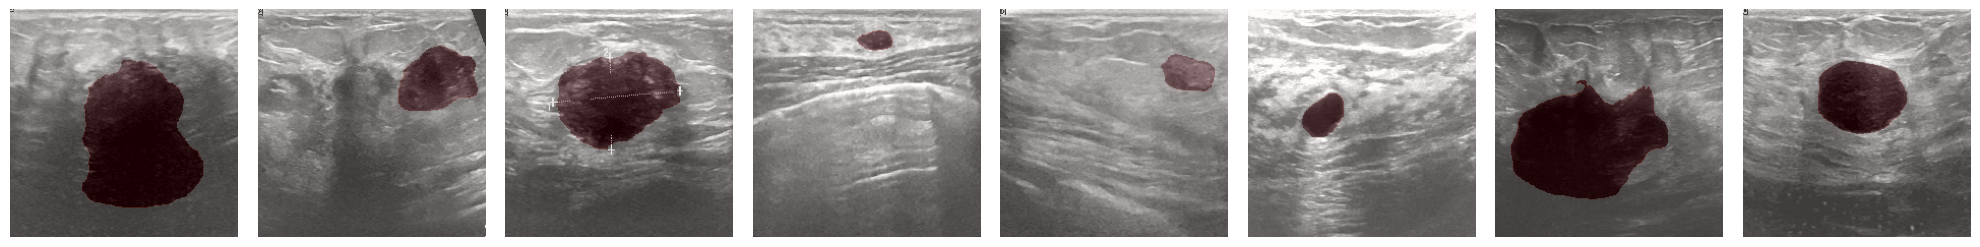

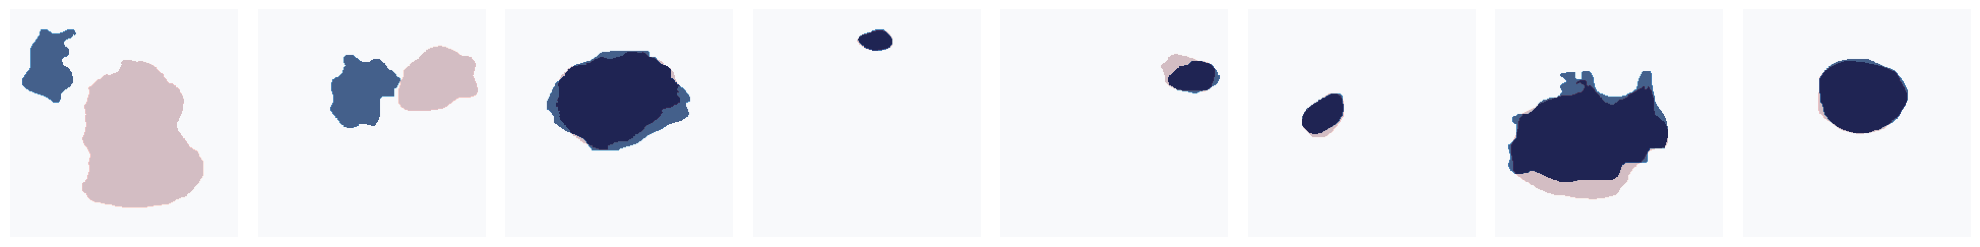

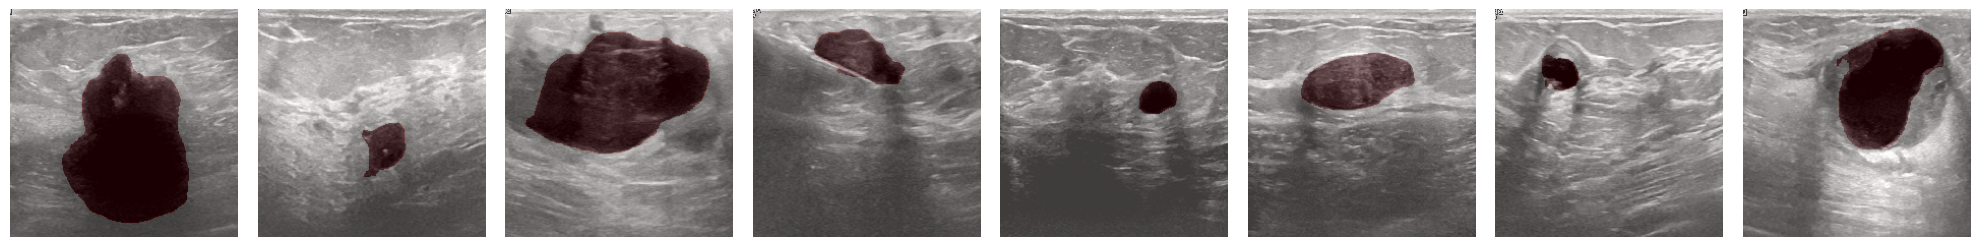

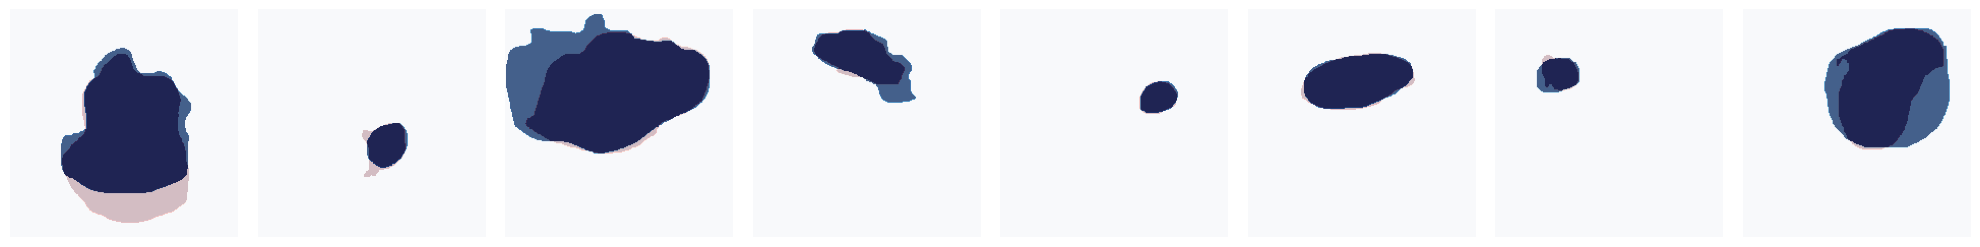

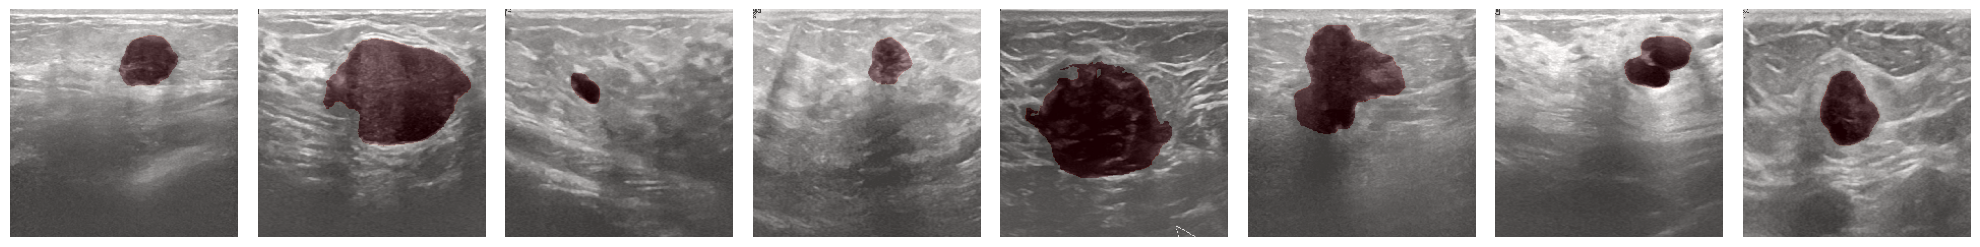

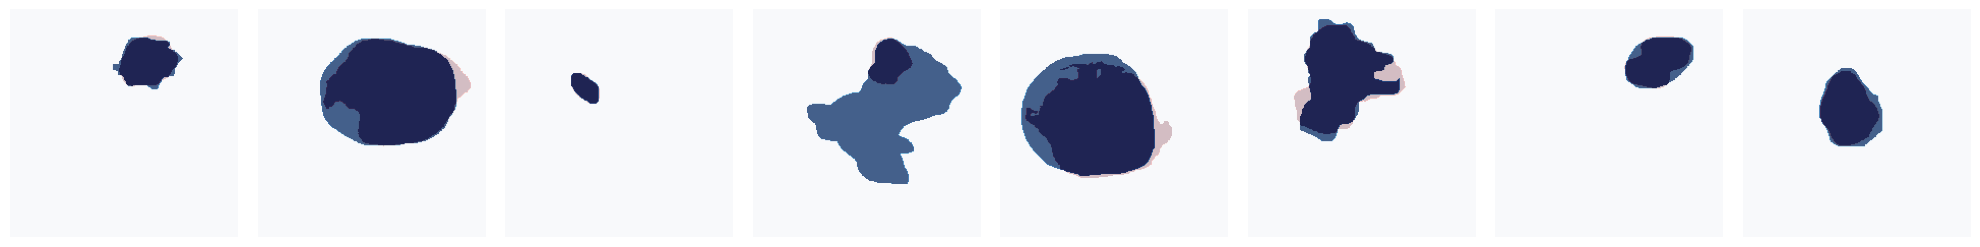

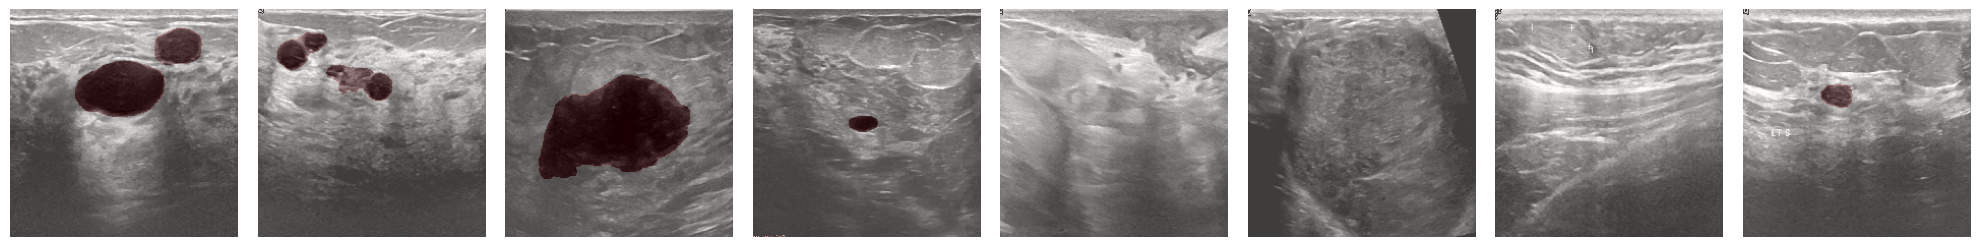

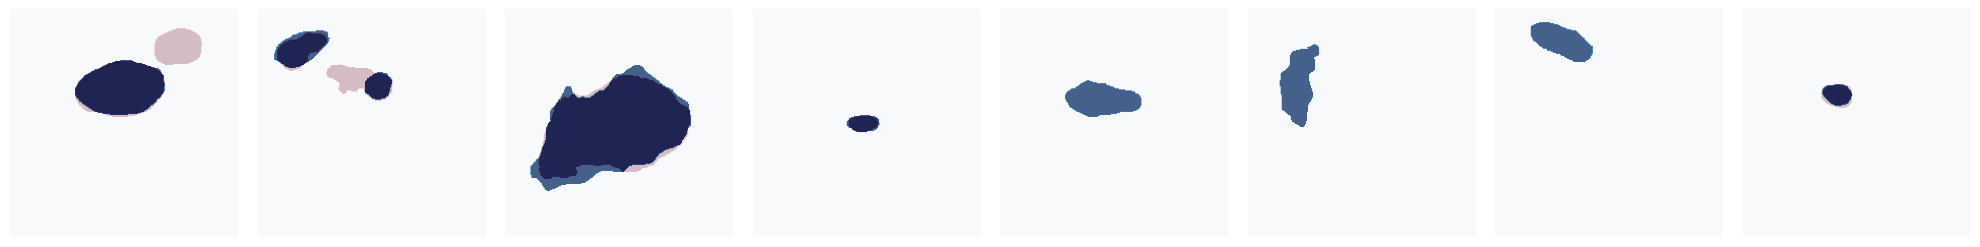

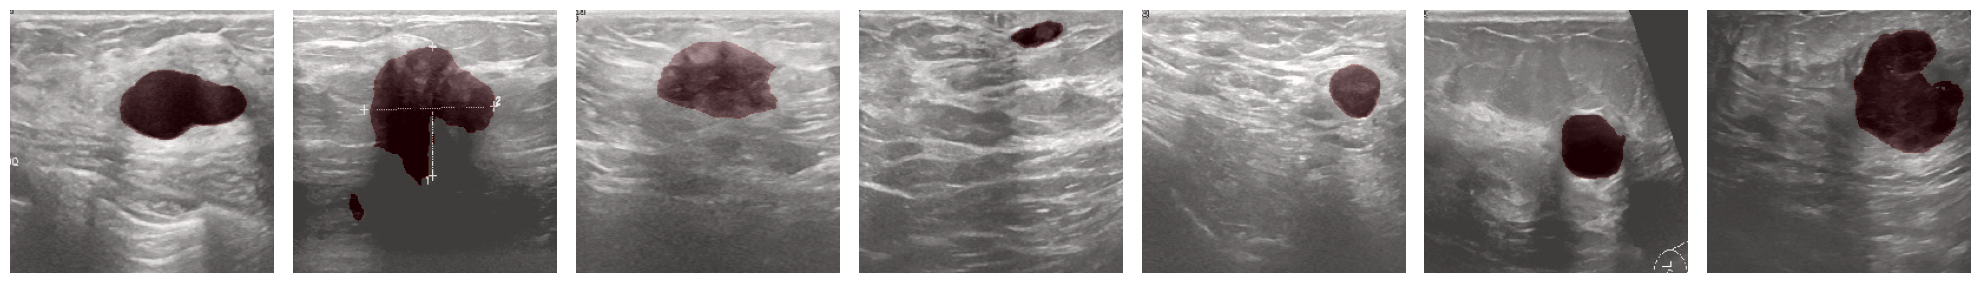

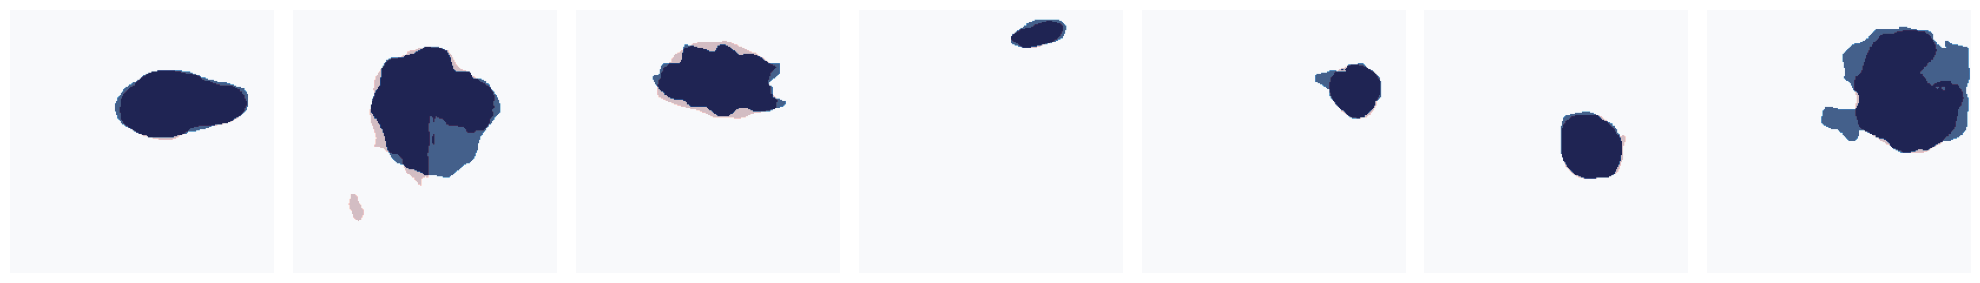

In [ ]:
for step, (imgs0, masks0, imgs, masks, coords, dim) in enumerate(test_loader):
    imgs = imgs.to(device, dtype=torch.float32)
    model = model.to(device)
    with torch.no_grad():
        scores = model(imgs)
        preds = torch.argmax(scores, dim=1).float()
        preds0 = preds_full_img(preds.unsqueeze(1), coords, dim)

    imgs = imgs.cpu()
    imgs0 = imgs0.cpu()
    masks0 = masks0.cpu()
    preds = preds.cpu()
    preds0 = preds0.cpu()

    #plot_mini_batch(imgs0) #full_images
    #plot_mini_batch(imgs) #crops
    #plot_mini_batch(imgs, preds.unsqueeze(1)) #segmentated crops
    #plot_mini_batch(imgs0, preds0)#segmentated full images
    #plot_mini_batch(imgs=masks0)
    plot_mini_batch(imgs0, preds0, len(imgs0))
    plot_mini_batch(masks0, preds0, len(masks0))

In [ ]:
acc = accuracy(model, test_loader)
print(f'acc: {acc[1]:.4f}, acc_full_img: {acc[4]:.4f}, dice: {acc[2]:.4f}, dice_full_img: {acc[5]:.4f}, iou: {acc[3]:.4f}, iou_full_img: {acc[6]:.4f}')
print(f'mean: {mean(acc[7]):.4f}, min: {min(acc[7]):.4f}, percentile-25th: {quantiles(acc[7])[0]:.4f}, median: {median(acc[7]):.4f}, percentile-75th: {quantiles(acc[7])[2]:.4f}, max: {max(acc[7]):.4f}, stdev: {stdev(acc[7]):.4f}')

acc: 0.9215, acc_full_img: 0.9598, dice: 0.8307, dice_full_img: 0.7914, iou: 0.7104, iou_full_img: 0.6549
mean: 0.7645, min: 0.0000, percentile-25th: 0.8186, median: 0.8873, percentile-75th: 0.9226, max: 0.9659, stdev: 0.3091


In [ ]:
for conf in range(0, 100, 5):
    nms_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format='xyxy',
        from_logits = False,
        iou_threshold=0.25,
        confidence_threshold=conf/100,
        max_detections=10
    )

    model_detector.prediction_decoder = nms_decoder
    test_dataset = BreastCancerDatasetFromDetector(X_test, transform_img, transform_mask, detector=model_detector)

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    acc = accuracy(model, test_loader)
    print(f'conf:{conf/100:.4f}, acc: {acc[1]:.4f}, acc_full_img: {acc[4]:.4f}, dice: {acc[2]:.4f}, dice_full_img: {acc[5]:.4f}, iou: {acc[3]:.4f}, iou_full_img: {acc[6]:.4f}')


In [ ]:
median(acc[7])

0.9109469354152679

In [ ]:
models = [f'{PATH}segmentation/results/best_69epochs_fold0_0.8544.pt',
          f'{PATH}segmentation/results/best_66epochs_fold1_0.8447.pt',
          f'{PATH}segmentation/results/best_76epochs_fold2_0.8377.pt',
          f'{PATH}segmentation/results/best_94epochs_fold3_0.8347.pt']
total_dices = []
total_ious = []
total_dices0 = []
total_ious0 = []
for fold in range(0,4):
    print(f'Fold: {fold}')
    torch.manual_seed(SEED)
    model = torch.load(models[fold])

    X_valid = busi_df[busi_df.test_fold == fold]
    print(f"  Valid: {X_valid.groupby(['class'])['class'].count().tolist()}")

    val_dataset = BreastCancerDataset(X_valid, transform_img, transform_mask)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_cost, val_acc, dice, iou, dices, ious, val_acc0, dice0, iou0, dices0, ious0 = accuracy(model, val_loader, crop_integration=True)

    total_dices += dices
    total_ious += ious
    print_stats('dice', dices)
    print_stats('iou', ious)
    total_dices0 += dices0
    total_ious0 += ious0
    print_stats('dice full image', dices0)
    print_stats('iou full image', ious0)

    print('**********************************')

print('All folds:')
print_stats('total_dice', total_dices)
print_stats('total_iou', total_ious)
print_stats('total_dice_full_image', total_dices0)
print_stats('total_iou_full_image', total_ious0)

Fold: 0
  Valid: [56, 41, 16]


KeyboardInterrupt: 

In [27]:
tf.config.run_functions_eagerly(True)

In [28]:
import torchvision
import torchvision.transforms as T

def mask_to_transparent_image(mask_array, color):
    mask = Image.fromarray(np.squeeze(mask_array, axis=2))
    grayscale_image = mask.convert('L')
    edges_image = grayscale_image.filter(ImageFilter.FIND_EDGES)
    thick_edges_image = edges_image.filter(ImageFilter.MaxFilter(3))
    colorized_edges_image = ImageOps.colorize(thick_edges_image, black="black", white="green")
    thick_edges_rgba = thick_edges_image.convert("RGBA")
    transparent_image = Image.new("RGBA", thick_edges_rgba.size, (0, 0, 0, 0))
    for y in range(thick_edges_rgba.height):
        for x in range(thick_edges_rgba.width):
            r, g, b, a = thick_edges_rgba.getpixel((x, y))
            if r > 0 or g > 0 or b > 0:  # Detect edges (white parts in the thick edges image)
                transparent_image.putpixel((x, y), color)  # Set edge color (blue) with full opacity
            else:
                transparent_image.putpixel((x, y), (0, 0, 0, 0))  # Set non-edge parts to transparent
    return transparent_image

def image_with_gt_and_pred(image_array, gt_mask_array=None, pred_mask_array=None):
    image = Image.fromarray(image_array.astype(np.uint8)).convert("RGBA")
    if gt_mask_array is not None:
        gt_mask = mask_to_transparent_image(gt_mask_array, (0, 0, 255, 255))
        image.paste(gt_mask, (0, 0), gt_mask)
    if pred_mask_array is not None:
        pred_mask = mask_to_transparent_image(pred_mask_array, (0, 255, 0, 255))
        image.paste(pred_mask, (0, 0), pred_mask)
    return np.asarray(image)


In [29]:
from keras_cv.visualization import draw_bounding_boxes
def show_images(model, loader, dices):
    index = 0
    for step, (imgs0, masks0, imgs, masks, boxes, coords, id_class, dim) in enumerate(loader):
        imgs = imgs.to(device, dtype=torch.float32)
        model = model.to(device)
        with torch.no_grad():
            scores = model(imgs)
            preds = torch.argmax(scores, dim=1).float()
            preds0 = preds_full_img(preds.unsqueeze(1), coords, dim)

        imgs = imgs.cpu()
        imgs0 = imgs0.cpu()
        masks0 = masks0.cpu()
        preds = preds.cpu()
        preds0 = preds0.cpu()
        print(dices[index:index + len(imgs0)])
        index += len(imgs0)
        print(id_class)
        plot_mini_batch_result(imgs0, masks0, preds0, len(imgs0), boxes)

In [33]:
'''
#20 junio
models = [f'{PATH}segmentation/results/best_180epochs_0.9073.pt',
          f'{PATH}segmentation/results/best_120epochs_0.8811.pt',
          f'{PATH}segmentation/results/best_107epochs_0.8821.pt',
          f'{PATH}segmentation/results/best_197epochs_0.8891.pt']
#21 junio
models = [f'{PATH}segmentation/results/best_69epochs_fold0_0.8544.pt',
          f'{PATH}segmentation/results/best_66epochs_fold1_0.8447.pt',
          f'{PATH}segmentation/results/best_76epochs_fold2_0.8377.pt',
          f'{PATH}segmentation/results/best_94epochs_fold3_0.8347.pt']

detectors = [f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_0_115epochs.weights.h5',
          f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_1_111epochs.weights.h5',
          f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_2_211epochs.weights.h5',
          f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_3_89epochs.weights.h5']

'''
detectors = [f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_0_111epochs.weights.h5',
         f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_1_76epochs.weights.h5',
         f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_2_70epochs.weights.h5',
         f'{PATH}kerascv/results/yolo_v8_m_backbone_coco_best_unique_bbox00_fold_3_118epochs.weights.h5']
models = [f'{PATH}segmentation/results/best_180epochs_0.9073.pt',
          f'{PATH}segmentation/results/best_120epochs_0.8811.pt',
          f'{PATH}segmentation/results/best_107epochs_0.8821.pt',
          f'{PATH}segmentation/results/best_197epochs_0.8891.pt']

'''
detectors = [f'{PATH}kerascv/results/best_models/yolo_v8_m_backbone_coco_best_map_unique_bbox_fold_0.weights.h5',
          f'{PATH}kerascv/results/best_models/yolo_v8_m_backbone_coco_best_map_unique_bbox_fold_1.weights.h5',
          f'{PATH}kerascv/results/best_models/yolo_v8_m_backbone_coco_best_map_unique_bbox_fold_2.weights.h5',
          f'{PATH}kerascv/results/best_models/yolo_v8_m_backbone_coco_best_map_unique_bbox_fold_3.weights.h5']

#retina_18
detectors = [f'{PATH}kerascv/results/retina18_best_unique_bbox_fold_0_49epochs.weights.h5',
         f'{PATH}kerascv/results/retina18_best_unique_bbox_fold_1_62epochs.weights.h5',
         f'{PATH}kerascv/results/retina18_best_unique_bbox_fold_2_75epochs.weights.h5',
         f'{PATH}kerascv/results/retina18_best_unique_bbox_fold_3_66epochs.weights.h5']
'''
total_dices = []
total_ious = []
total_dices0 = []
total_ious0 = []
total_classes = torch.tensor([], dtype=int, device=device)
for fold in range(0,4):
    print(f'Fold: {fold}')
    torch.manual_seed(SEED)
    model = torch.load(models[fold])

    X_valid = busi_df[(busi_df.test_fold == fold)]
    print(f"  Valid: {X_valid.groupby(['class'])['class'].count().tolist()}")

    prediction_decoder = keras_cv.layers.NonMaxSuppression(
            bounding_box_format=BOUNDING_BOX_FORMAT,
            from_logits = False,
            iou_threshold=0.,
            confidence_threshold=0.25,
            max_detections=1
        )

    model_detector = keras_cv.models.YOLOV8Detector(
            num_classes=2,
            bounding_box_format='xyxy',
            backbone=keras_cv.models.YOLOV8Backbone.from_preset(DETECTOR)
    )
    '''
    model_detector = keras_cv.models.RetinaNet(
        num_classes=2,
        bounding_box_format='xyxy',
        backbone=(keras_cv.models.ResNet18Backbone(include_rescaling=True, input_shape=(224, 224, 3)).from_preset("resnet18"))
    )
    '''
    model_detector.prediction_decoder = prediction_decoder
    model_detector.load_weights(detectors[fold])

    val_dataset = BreastCancerDatasetFromDetector(X_valid, transform_img, transform_mask, model_detector)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    val_cost, val_acc, dice, iou, dices, ious, val_acc0, dice0, iou0, dices0, ious0, classes = accuracy(model, val_loader, crop_integration=True, index=len(total_dices0))
    total_classes = torch.cat((total_classes, classes), 0)
    total_dices += dices
    total_ious += ious
    print_stats('dice', dices)
    print_stats('iou', ious)
    total_dices0 += dices0
    total_ious0 += ious0
    print_stats('dice full image', dices0)
    print_stats('iou full image', ious0)
    print('**********************************')
    #show_images(model, val_loader, dices0)
print('All folds:')
print_stats('total_dice', total_dices)
print_stats('total_iou', total_ious)
print_stats('total_dice_full_image', total_dices0)
print_stats('total_iou_full_image', total_ious0)

Fold: 0
  Valid: [56, 41, 16]
5
tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0', dtype=torch.int32)
[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
tensor([   0,    0, 2250,    0,    0,    0,    0,    0], device='cuda:0')
tensor([[ -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1],
        [ 66, 162, 147, 224],
        [ -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1],
        [ -1,  -1,  -1,  -1]], device='cuda:0', dtype=torch.int32)
dice - mean: 0.7761, min: 0.0000, percentile-25th: 0.8212, median: 0.9102, percentile-75th: 0.9486, max: 1.0000, stdev: 0.3201
iou - mean: 0.7147, min: 0.0000, percentile-25th: 0.6967, median: 0.8352, percentile-75th: 0.9023, max: 1.0000, stdev: 0.3149
dice full image - mean: 0.7661, min: 0.0000, percentile-25th: 0.8031, median: 0.9111, percentile-75th: 0.9438, max: 1.0000, stdev: 0.3251
iou full image - mean: 0.7035, min: 0.0000, percentile-25th: 0.6710, median: 0.8367, percentile-75th: 0.8936, max: 1

ValueError: Input 0 of layer "yolov8_detector_6" is incompatible with the layer: expected shape=(None, None, None, 3), found shape=(1, 224, 224, 4)

In [ ]:
print(class_mapping[0])

benign


In [ ]:
print(total_dices0)

[0.8338108658790588, 0.9682080745697021, 0.0, 0.9198606014251709, 0.8963996767997742, 0.9251563549041748, 0.0, 0.9047372341156006, 0.7001254558563232, 0.9490119814872742, 0.9404579997062683, 0.7795857787132263, 0.9541248083114624, 0.9404035806655884, 0.6744263172149658, 0.0, 0.6000000238418579, 0.8778705596923828, 0.8746031522750854, 0.8885191082954407, 0.9475340843200684, 0.9694444537162781, 0.5262076258659363, 0.4390665590763092, 0.9761698246002197, 0.9214290976524353, 0.5778020620346069, 0.8706134557723999, 0.0, 0.9134328365325928, 0.9097586274147034, 0.8976660966873169, 0.907755970954895, 0.8459578156471252, 0.0, 0.9616497159004211, 0.0, 0.9168806672096252, 0.2997434437274933, 0.7665100693702698, 0.9724521636962891, 0.8184744715690613, 0.5637603998184204, 0.9228032827377319, 0.9729135036468506, 0.9293993711471558, 0.815543532371521, 0.8003153204917908, 0.8289908766746521, 0.7897551655769348, 0.87301105260849, 0.8900269269943237, 0.4993511438369751, 0.8884041905403137, 0.75853019952

In [ ]:
ious=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [ ]:
sum(1 for x in ious)

In [ ]:
dices_ious = [x for x,y in zip(total_dices0, ious) if y == 1]
ious_ious = [x for x,y in zip(total_ious0, ious) if y == 1]
print_stats('total_dice_iou_0_5', dices_ious)
print_stats('total_iou_iou_0_5', ious_ious)

total_dice_iou_0_5 - mean: 0.7900, min: 0.0000, percentile-25th: 0.7982, median: 0.9035, percentile-75th: 0.9437, max: 1.0000, stdev: 0.2872
total_iou_iou_0_5 - mean: 0.7197, min: 0.0000, percentile-25th: 0.6642, median: 0.8240, percentile-75th: 0.8934, max: 1.0000, stdev: 0.2870


<ipython-input-45-731c64d3a231>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(data=graph, x='classes', y='dices', palette='pastel', width=0.3)
<ipython-input-45-731c64d3a231>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  boxplot.set_xticklabels(['Benigno', 'Maligno', 'Normal'], fontsize=12)


[Text(0, 0, 'Benigno'), Text(1, 0, 'Maligno'), Text(2, 0, 'Normal')]

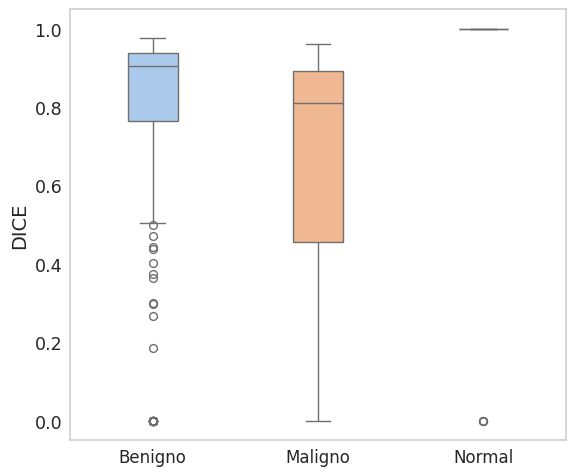

In [ ]:
import seaborn as sns
graph = {'dices': np.asarray(total_dices0), 'classes': total_classes.cpu().numpy()}


boxplot = sns.boxplot(data=graph, x='classes', y='dices', palette='pastel', width=0.3)
boxplot.set_xlabel('', fontsize=14)
boxplot.set_ylabel('DICE', fontsize=14)
boxplot.grid(visible=False)

boxplot.set_xticklabels(['Benigno', 'Maligno', 'Normal'], fontsize=12)

In [ ]:
elems=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
sum(x for x in elems)


315

In [ ]:
ious=

In [ ]:
sum(1 for x in ious)

840

In [ ]:
salida = [(x,y,z) if x>0 and y==0 else None for x,y,z in zip(total_dices0, ious, total_classes.cpu().numpy())]
salida

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 (1.0, 0.0, 2),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 Non

In [ ]:
[i for i in range(len(salida)) if salida[i] != None]

[109, 268, 296]

In [ ]:
graph = {'dices': np.asarray(total_dices0), 'classes': total_classes.cpu().numpy(), 'ious': ious }

scatter = sns.scatterplot(data=graph, x="ious", y="dices", hue="classes", palette="deep")
scatter.set_xlabel('Detection - IoU', fontsize=14)
scatter.set_ylabel('Segmentation - DICE', fontsize=14)
scatter.grid(visible=False)
scatter.legend(title=None, labels=['Benigno', 'Maligno', 'Normal'])
sns.move_legend(scatter, "upper left", bbox_to_anchor=(1, 1))

NameError: name 'sns' is not defined

In [ ]:
[i for i in range(len(test_list)) if test_list[i] != None]